In [1]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from matplotlib.colors import ListedColormap

# Performance measures
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn



# Compsci 361 Assignment 3
James Tong, Jeff Smith, Lucia Kim, Natasha Ng

The aim of the assignment is to clasisfy BBC articles as tech news or entertainment news. Naive Bayes, k Nearest Neighbours, Support Vector Machines and Neural Network supervisesd learning algorithms are investigated.

## Task 1: Exploratory data analytics on text data


### a) Feature vector
For these articles, we peformed vectorisation using term frequency - inverse document frequency as a way of tokenising the texts. The term frequency is the proportion of times the term appears in the document. The inverse document frequency adjusts common words that appear in the samples. By multipling the term frequency and the inverse document frequency, higher importance is given to terms when it occurs often in the document and less in other documents.

By fitting the TfidfVectoriser on the training set, each text is represented as a vector of fixed size. From this, we observed 13518 unique words becoming our features from 428 articles. The 5 example articles and their extracted features are shown below.

In [2]:
# import data
data_train_csv = pd.read_csv("train.csv")
data_test_csv = pd.read_csv("test.csv")

# construct feature vector
tfid = TfidfVectorizer()
tfid.fit(data_train_csv["Text"])

tfidDF = tfid.transform(data_train_csv["Text"])

# number of articles and features
num_articles = tfidDF.shape[0]
num_features = tfidDF.shape[1]

print(f"Number of articles: {num_articles}")
print(f"Number of extracted features: {num_features}")

# 5 example articles
fivearticles = data_train_csv["Text"].head(5)
features = tfidDF[:5].toarray()
feature_names = tfid.get_feature_names_out()

example_df = pd.DataFrame(features, columns=feature_names, index=fivearticles)

print(example_df.head())

Number of articles: 428
Number of extracted features: 13518
                                                     00       000  000th  \
Text                                                                       
lifestyle governs mobile choice faster better f...  0.0  0.020115    0.0   
french honour director parker british film dire...  0.0  0.000000    0.0   
fockers fuel festive film chart comedy meet foc...  0.0  0.000000    0.0   
housewives lift channel 4 ratings debut us tele...  0.0  0.000000    0.0   
u2 desire number one u2 three prestigious gramm...  0.0  0.000000    0.0   

                                                    001st  0051  007  0100  \
Text                                                                         
lifestyle governs mobile choice faster better f...    0.0   0.0  0.0   0.0   
french honour director parker british film dire...    0.0   0.0  0.0   0.0   
fockers fuel festive film chart comedy meet foc...    0.0   0.0  0.0   0.0   
housewives lift c

### b) Frequency analysis
Count vectoriser has been used for frequency analysis. From looking at the above plots, we notice "said" was mentioned the most frequently across all articles, surpassing the closest frequent word by over two times. The remaining top term frequencies seems quite consistent ranging from 600 down to 200. We also see "said" is most frequent in the category tech compared to entertainment. Overall, the data seems fairly balanced with similar number of articles for each category. 


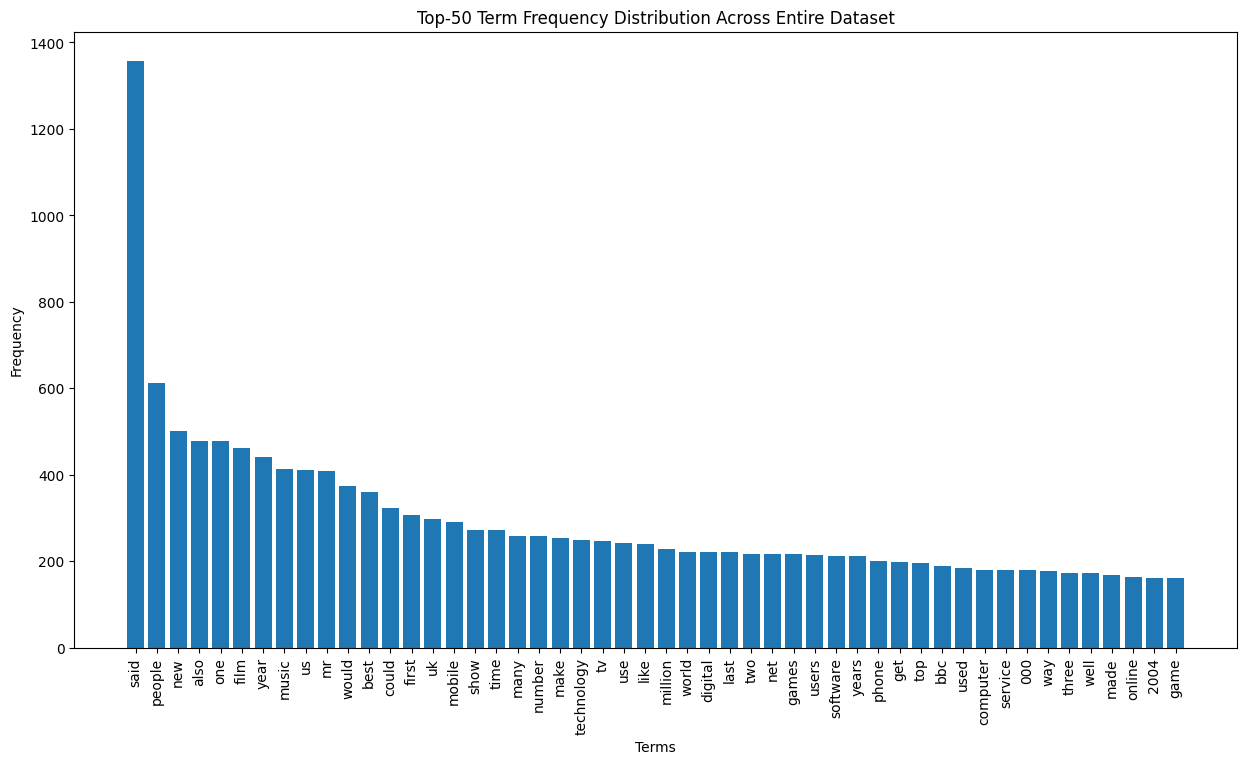

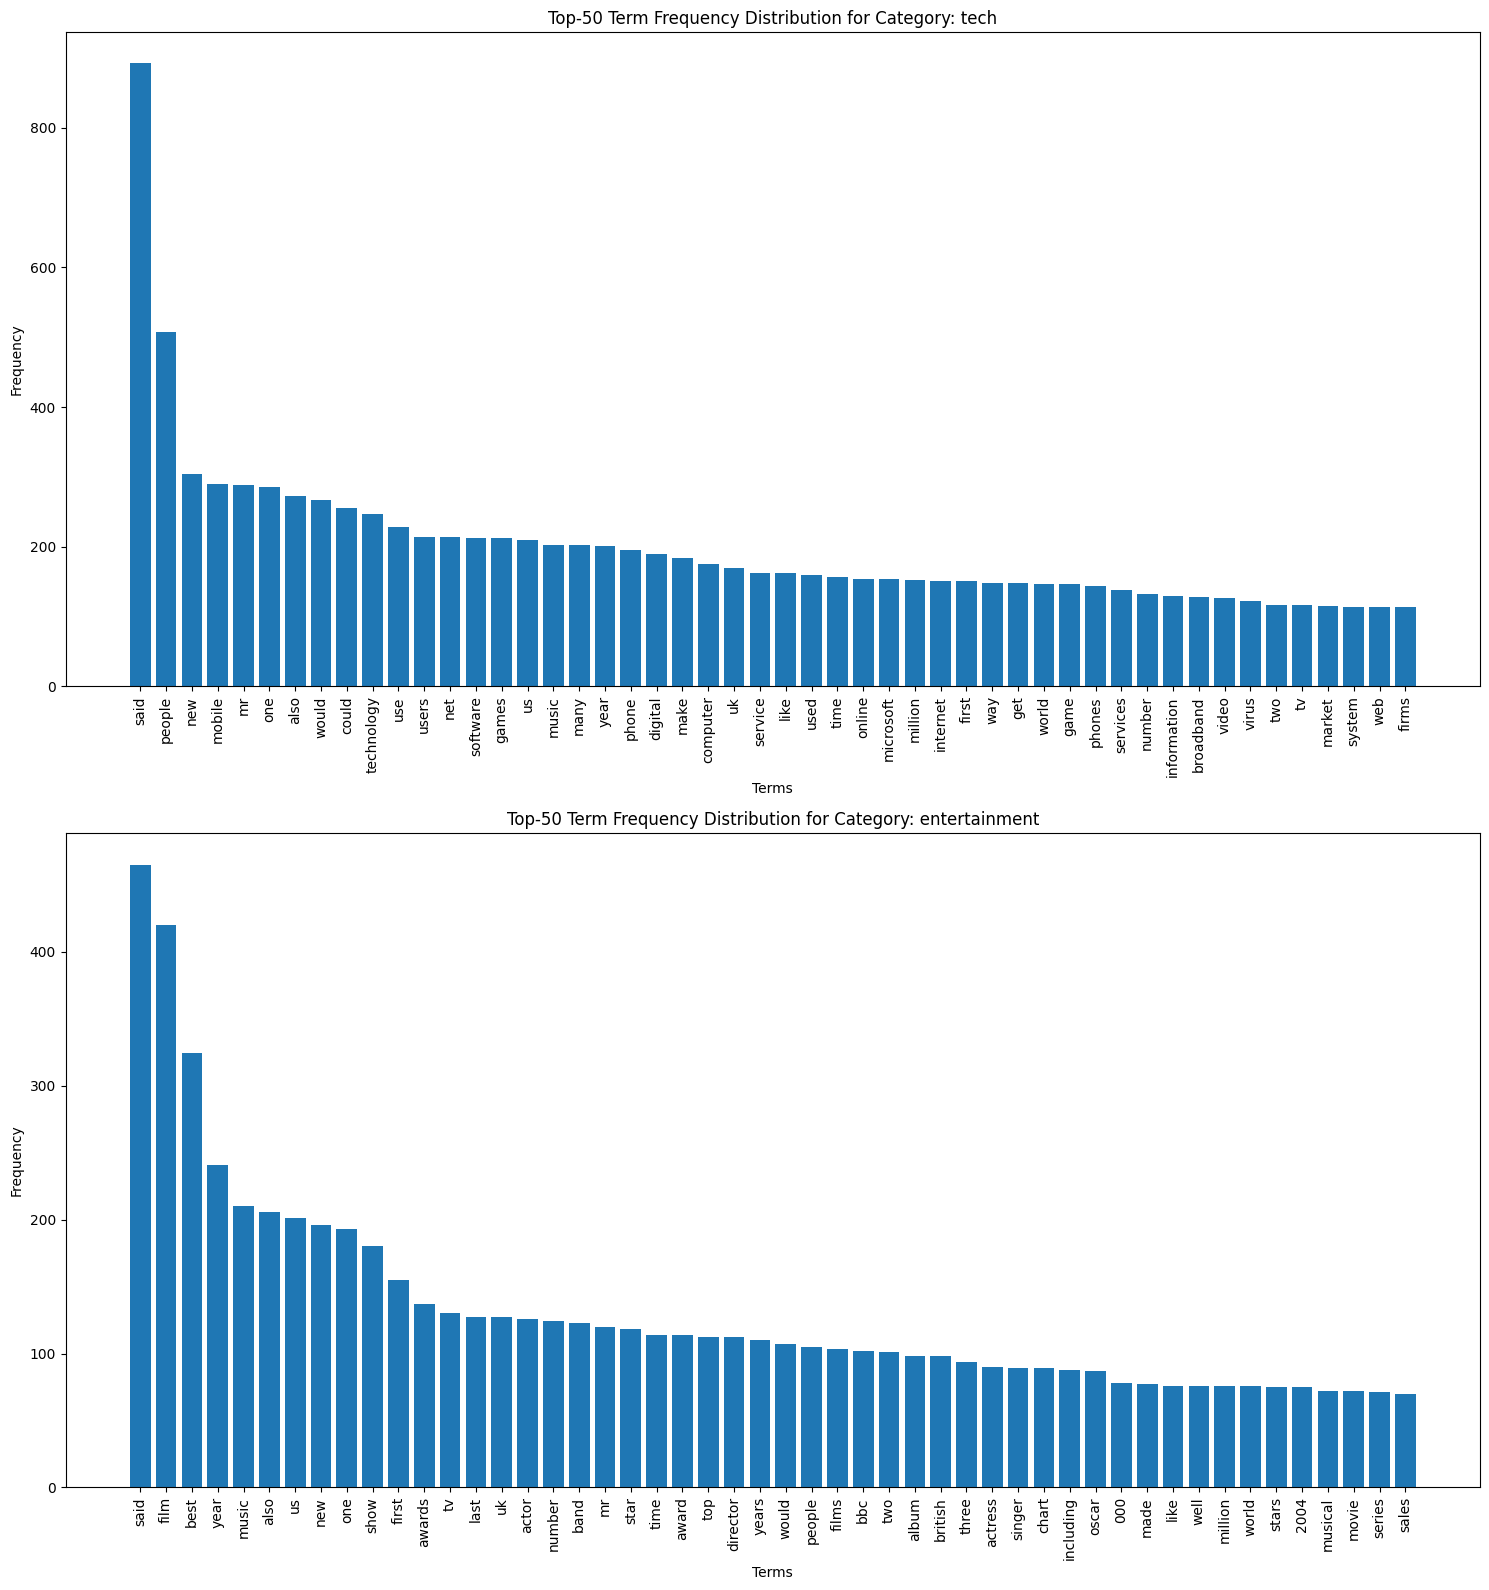

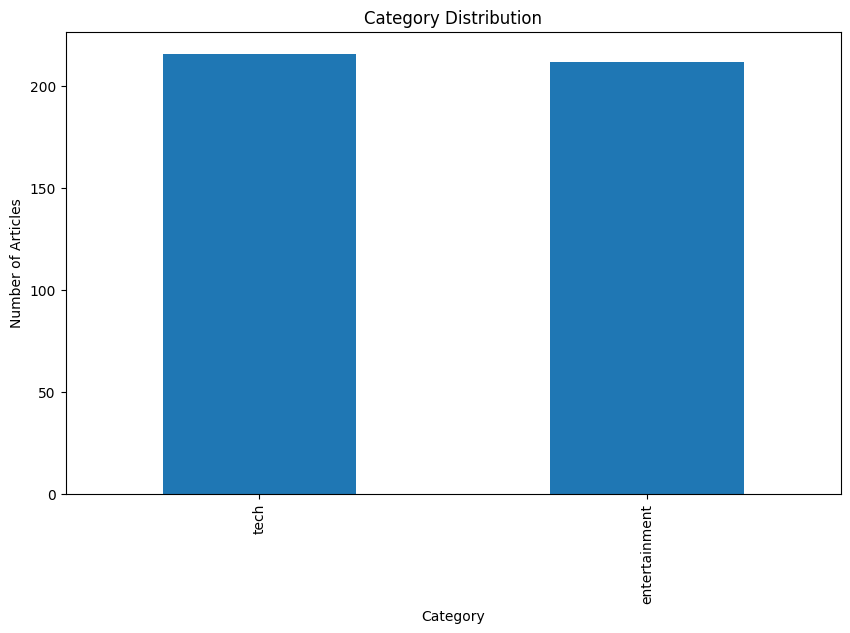

In [3]:
# construct feature vector using term frequency
vectorizer = CountVectorizer()

word_matrix = vectorizer.fit_transform(data_train_csv["Text"])
word_hz = word_matrix.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()

term_freq_df = pd.DataFrame({'term': terms, 'frequency': word_hz})
term_freq_df = term_freq_df.sort_values(by='frequency', ascending=False)

#plot 1
plt.figure(figsize=(15, 8))
top50 = term_freq_df.head(50)
plt.bar(top50['term'], top50['frequency'])
plt.xticks(rotation=90)
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.title('Top-50 Term Frequency Distribution Across Entire Dataset')
plt.show()

categories = data_train_csv['Category'].unique()
term_hz = {}

for category in categories:
    category_texts = data_train_csv[data_train_csv['Category'] == category]['Text']
    category_word_matrix = vectorizer.transform(category_texts)
    category_word_hz = category_word_matrix.sum(axis=0).A1
    term_hz[category] = category_word_hz

#plot 2&3
fig, axes = plt.subplots(len(categories), 1, figsize=(15, 8 * len(categories)))

for i, category in enumerate(categories):
    term_freqDF = pd.DataFrame({'term': terms, 'frequency': term_hz[category]})
    term_freqDF = term_freqDF.sort_values(by='frequency', ascending=False)
    top50_terms = term_freqDF.head(50)
    
    axes[i].bar(top50_terms['term'], top50_terms['frequency'])
    axes[i].set_xticks(range(len(top50_terms['term'])))
    axes[i].set_xticklabels(top50_terms['term'], rotation=90)
    axes[i].set_xlabel('Terms')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Top-50 Term Frequency Distribution for Category: {category}')

plt.tight_layout()
plt.show()

#plot 4
plt.figure(figsize=(10, 6))
category_distribution = data_train_csv['Category'].value_counts()
category_distribution.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.title('Category Distribution')
plt.show()

## Task 2: Classification Models Learning
ClassifNaive Bayes, K Nearest Neighbours, Support Vector Machine, and Neural Network supervised learning algorithms are trained to classify BBC articles into entertainment news or tech news. The effect of different hyperparameters are investigated. The "tech" category is considered positive.

In [4]:
# All training data
X_all = data_train_csv["Text"]
tfidf_all = TfidfVectorizer()
X_all_tfidf = tfidf_all.fit_transform(X_all)
y_all = data_train_csv["Category"]
y_testing = data_test_csv["Category"]

# Vectorizing after data split
X_train, X_test, y_train, y_test = train_test_split(data_train_csv["Text"], data_train_csv["Category"], test_size=0.2,random_state=42)

#Tfid Vectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#Count Vectorizer
vectorizer = CountVectorizer()
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)
X_all_count = vectorizer.fit_transform(data_train_csv["Text"])
testing = vectorizer.transform(data_test_csv["Text"])

Helper functions

In [5]:
def plot_surface(pca, X, y, classifier, ax, resolution=0.005, inverse_transform=True, decision_margin=False):
    if ax is None:
        ax = plt.gca()

    # plot the decision surface
    markers = ('s', 'o')
    colors = ('deepskyblue', 'orangered')
    cmap = ListedColormap(colors)

    # set pixel grid for 2D surface plot
    x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    # classiy every point on pixel grid
    if inverse_transform:
        Z = classifier.predict(pca.inverse_transform(
            np.array([xx1.ravel(), xx2.ravel()]).T)
            )
    else:
        Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)

    # Convert levels to numbers
    Z = np.where(Z == "entertainment", 0, 1)
    Z = Z.reshape(xx1.shape)

    # Built contours
    ax.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)     
  
    # Plot training points
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label= f'class {cl}', 
                    edgecolor='k')
     
    
    # create grid to evaluate classifier
    if decision_margin:
        # y = np.arange(x1_min, x1_max, resolution)
        # x = np.arange(x2_min, x2_max, resolution)
        # Y, X = np.meshgrid(y, x)
        # xy = np.vstack([X.ravel(), Y.ravel()]).T
        # P = classifier.decision_function(pca.inverse_transform(xy)).reshape(X.shape)
        
        # # plot decision boundary and margins
        # ax.contour(X, Y, P, colors='k',
        #         levels=[-1, 0, 1], alpha=0.5,
        #         linestyles=['--', '-', '--'])
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        x = np.linspace(xlim[0], xlim[1], 30)
        y = np.linspace(ylim[0], ylim[1], 30)
        Y, X = np.meshgrid(y, x)
        xy = np.vstack([X.ravel(), Y.ravel()]).T
        P = classifier.decision_function(xy).reshape(X.shape)
        
        # plot decision boundary and margins
        ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # Set lables
    ax.set_xlabel('principle component 1', size=16)
    ax.set_ylabel('principle component 2', size=16)
    ax.legend(loc='upper left', fontsize=16)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())


### Task 2.a) Naive Bayes
All articles features are used to train the Naive Bayes classifer.

#### i)
These are the top-20 most identifiiable words that are most likely to occur for the each category.

Entertainment: ['film' 'band' 'album' 'best' 'actor' 'singer' 'oscar' 'star' 'award'
 'chart' 'musical' 'theatre' 'stars' 'rock' 'comedy' 'song' 'festival'
 'elvis' 'awards' 'nominations']

Technology: ['mobile' 'software' 'games' 'microsoft' 'virus' 'users' 'technology'
 'net' 'phone' 'broadband' 'phones' 'computer' 'spyware' 'search' 'pc'
 'firms' 'use' 'mail' 'data' 'game']

In [6]:
NBmodel = MultinomialNB()

NBmodel.fit(X_train_count, y_train)
pred = NBmodel.predict(X_test_count)

print('Gaussian Naive Bayes')
print('Accuracy:', accuracy_score(y_test, pred))
print('Classification Report:')
print(classification_report(y_test, pred))


Gaussian Naive Bayes
Accuracy: 0.9767441860465116
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      0.97      0.97        38
         tech       0.98      0.98      0.98        48

     accuracy                           0.98        86
    macro avg       0.98      0.98      0.98        86
 weighted avg       0.98      0.98      0.98        86



In [7]:


NBmodel = MultinomialNB()

NBmodel.fit(X_train_tfidf, y_train)
pred = NBmodel.predict(X_test_count)

# print('Gaussian Naive Bayes')
# print('Accuracy:', accuracy_score(y_test, pred))               
# print('Classification Report:')
# print(classification_report(y_test, pred))


In [8]:
# finding the best 20 words:
num_words = 20

log_probabilities = NBmodel.feature_log_prob_

words = vectorizer.get_feature_names_out()

change_log_probabilities_entertainment = [log_probabilities[0][i] - log_probabilities[1][i] for i in range(len(log_probabilities[0]))]
change_log_probabilities_tech = [log_probabilities[1][i] - log_probabilities[0][i] for i in range(len(log_probabilities[0]))]

value_order_entertainment = np.argsort(change_log_probabilities_entertainment)
value_order_tech = np.argsort(change_log_probabilities_tech)

best_20_entertainment = value_order_entertainment[len(log_probabilities[0]) - num_words:][::-1]
best_20_tech = value_order_tech[len(log_probabilities[0]) - num_words:][::-1]

print(f'Best {num_words} words for predicting entertainment were: {words[best_20_entertainment]}\n')
print(f'Best {num_words} words for predicting tech were: {words[best_20_tech]}\n')

Best 20 words for predicting entertainment were: ['erratic' 'augmented' 'afford' 'basically' 'accommodate' 'renowned'
 'mighty' 'ruby' 'aston' 'captures' 'lousy' 'skateboards' 'ruined'
 'profound' 'chorus' 'revolutionalised' 'entrepreneurs' 'distributing'
 'astonishing' 'markova']

Best 20 words for predicting tech were: ['lifetime' 'returned' 'fest' 'leaves' 'surfing' 'sub' 'sic' 'makeover'
 'negative' 'bomb' 'negligence' 'click' 'rosencrantz' 'rate' 'mulls'
 'evening' 'stupid' 'julie' 'corbijn' 'fergie']



#### ii)

the top-20 words that maximize the following quantity:
𝑷(𝑿𝒘 = 𝟏|𝒀 = 𝒚)
𝑷(𝑿𝒘 = 𝟏|𝒀 ≠ 𝒚)

In [9]:
probabilities = np.exp(log_probabilities)

#quantity formula
ratio_entertainment = probabilities[0]/probabilities[1]
ratio_tech = probabilities[1]/probabilities[0]

top20_ratio_entertainement = np.argsort(ratio_entertainment)[-20:]
top20_ratio_tech = np.argsort(ratio_tech)[-20:]
entertain_ratio20 = [words[i] for i in top20_ratio_entertainement]
tech_ratio20 = [words[i] for i in top20_ratio_tech]


print(f'Top 20 words for maximising the given quantity for entertainement class: {entertain_ratio20}\n')
print(f"Top 20 words maximizing the given quantity for tech class: {tech_ratio20}\n")

Top 20 words for maximising the given quantity for entertainement class: ['markova', 'astonishing', 'distributing', 'entrepreneurs', 'revolutionalised', 'chorus', 'profound', 'ruined', 'skateboards', 'lousy', 'captures', 'aston', 'ruby', 'mighty', 'renowned', 'accommodate', 'basically', 'afford', 'augmented', 'erratic']

Top 20 words maximizing the given quantity for tech class: ['fergie', 'corbijn', 'julie', 'stupid', 'evening', 'mulls', 'rate', 'rosencrantz', 'click', 'negligence', 'bomb', 'negative', 'makeover', 'sic', 'sub', 'surfing', 'leaves', 'fest', 'returned', 'lifetime']



From comparing and looking at the two lists above, it seems there is not a particular noticable difference in word types. It seems with both methods we are getting an accurate list of words that can help identify which class type the articles are from. However, I would argue the second method is better because of its simple formularic properties in describing the ratio of words being present in certain classes.

### Task 2.b) k Nearest Neighbours

#### Surface plot of kNN
The surface plot below is an example of training the k-Nearest Neighbour using all of the training set. The hyperaparamters for this example is: 5 nearest neighbours, and using the Euclidean matrix. The tf-idf vectoriser has been used to numerically represent the traininng data. PCA using Truncated SVD has been used to project the data to a 2D plane.

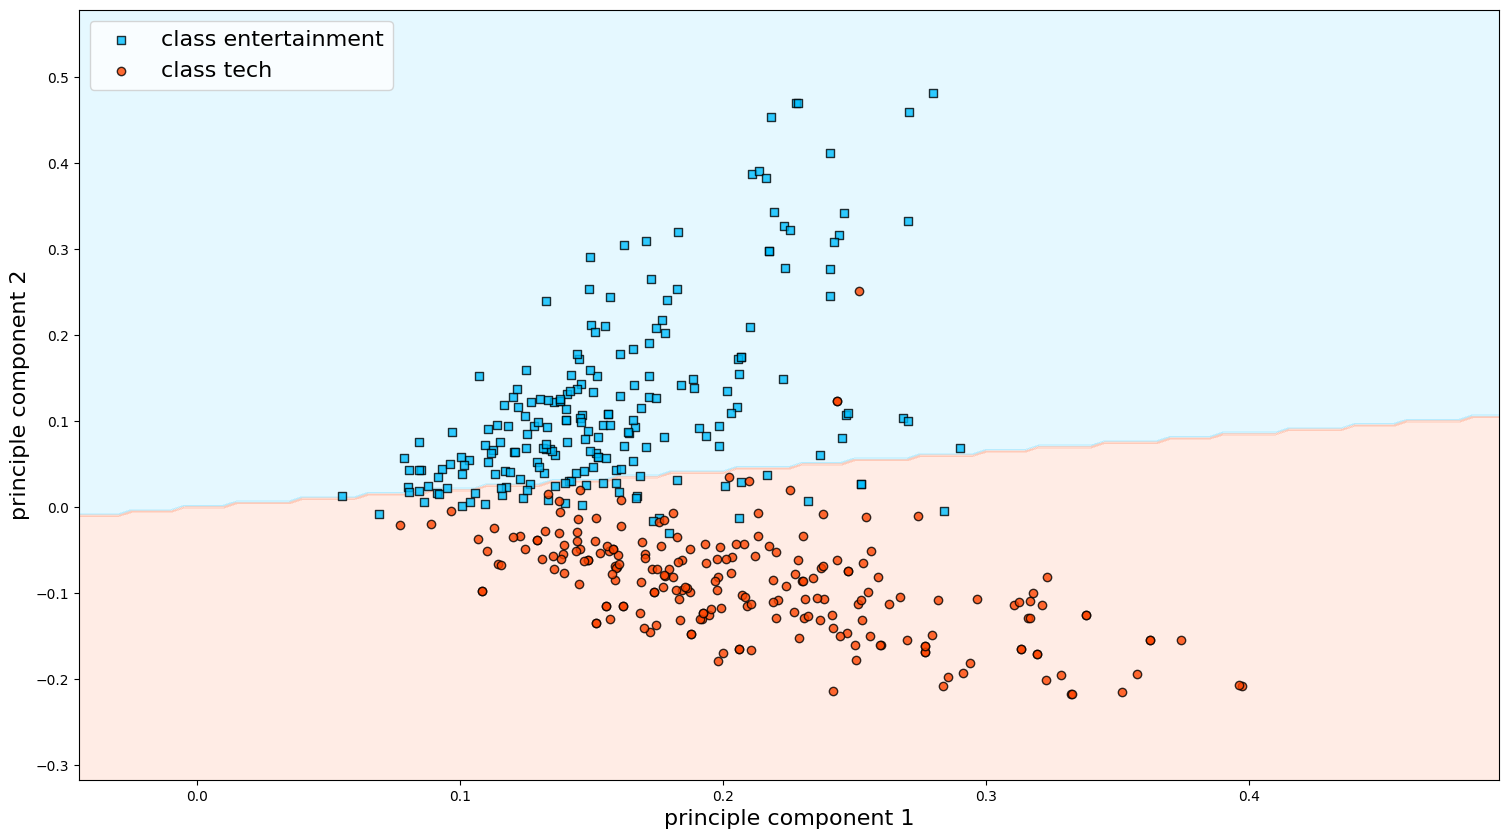

In [19]:
pca_knn = TruncatedSVD(n_components=2)
pca_tfidf = pca_knn.fit_transform(X_all_tfidf)

knn_best_all = KNeighborsClassifier(n_neighbors = 5, metric = "euclidean")
knn_best_all.fit(X_all_tfidf, y_all)

fig, ax_pca = plt.subplots(1, 1, figsize=(16, 10))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

plot_surface(pca_knn, pca_tfidf, y_all, knn_best_all, ax_pca)

#### Impact of k on the decision boundary

Two sets of surface plots have been plotted. The first set describes the decision boundary, where the kNN classifier predicts the category before the transformation has been applied. In other wrods, inverse transformatio has been used to predict each point on the 2D surface plot.

Most of the information has been removed through reducing the tf-idf vector into 2 dimensions. Even after the inverse transformation, an accurate representation of the decison boundary is not formed.

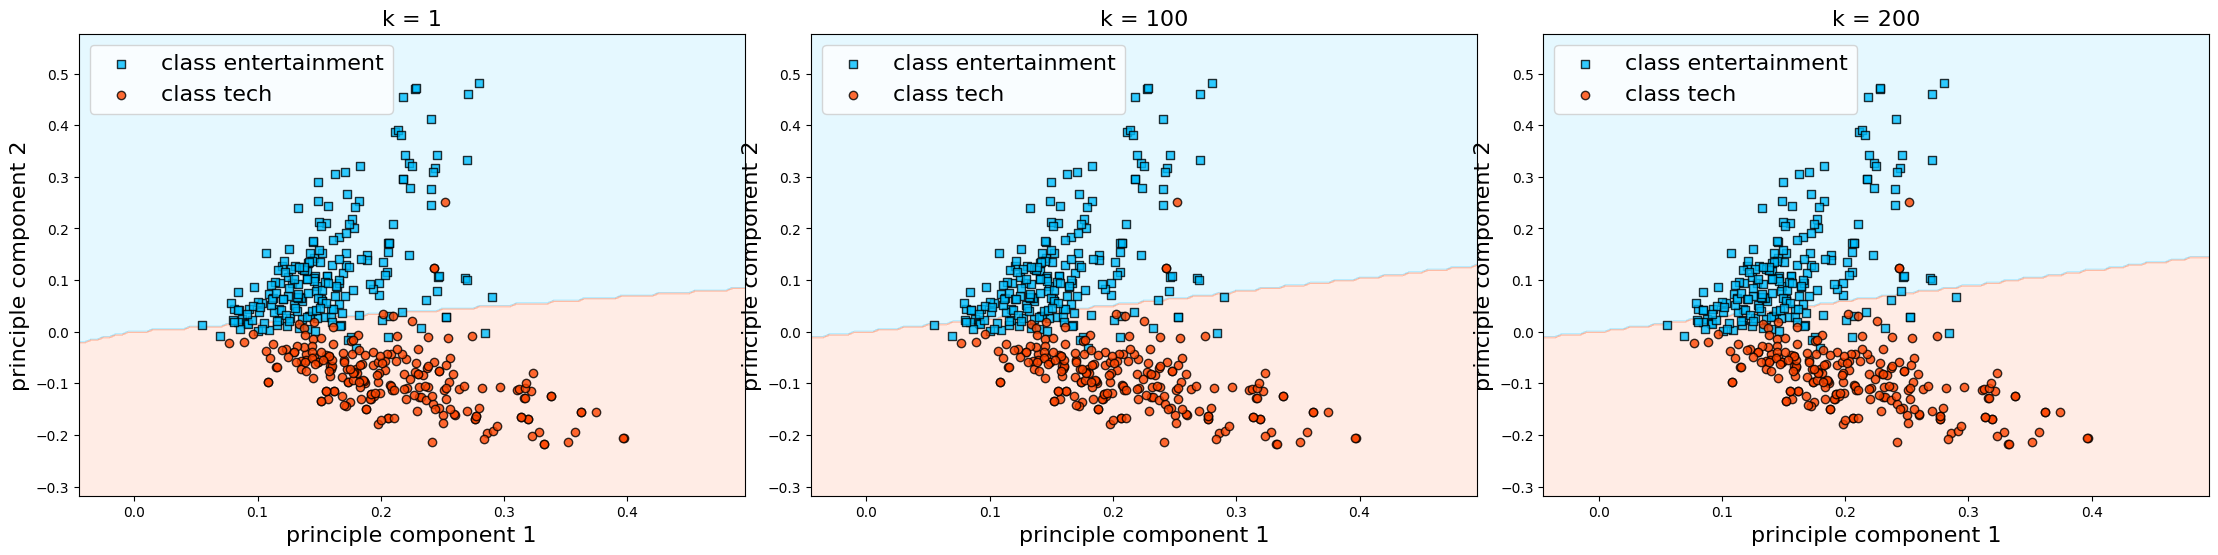

In [20]:
pca_knn = TruncatedSVD(n_components=2)
pca_train_tfidf = pca_knn.fit_transform(X_all_tfidf)

fig, ax = plt.subplots(1, 3, figsize=(24, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, k in zip(ax, [1, 100, 200]): 
    model = KNeighborsClassifier(n_neighbors=k, metric="euclidean").fit(X_all_tfidf, y_all)
    plot_surface(pca_knn, pca_train_tfidf, y_all, model, axi)
    axi.set_title(f'k = {k}', size=16)

Therefore, the second set of surface plots describe the decision boundary of the two principal components of the tf-idf vector. In other words, the k Nearest Neighbour classifer was trained after the dimensionality reduction. The f1 measure of the classifer will decrease if this classifer is used.

As k, the number of neighbours, increases, overfitting is reduced. When k = 1, the classifier is heavily affected by the individual points. The impact is redcued for k = 5. By k = 10, the two regions of entertainment and tech categories are divided clearly. When k = 50, boundary is sooth and overfits less to the individaul samples along the boundary.



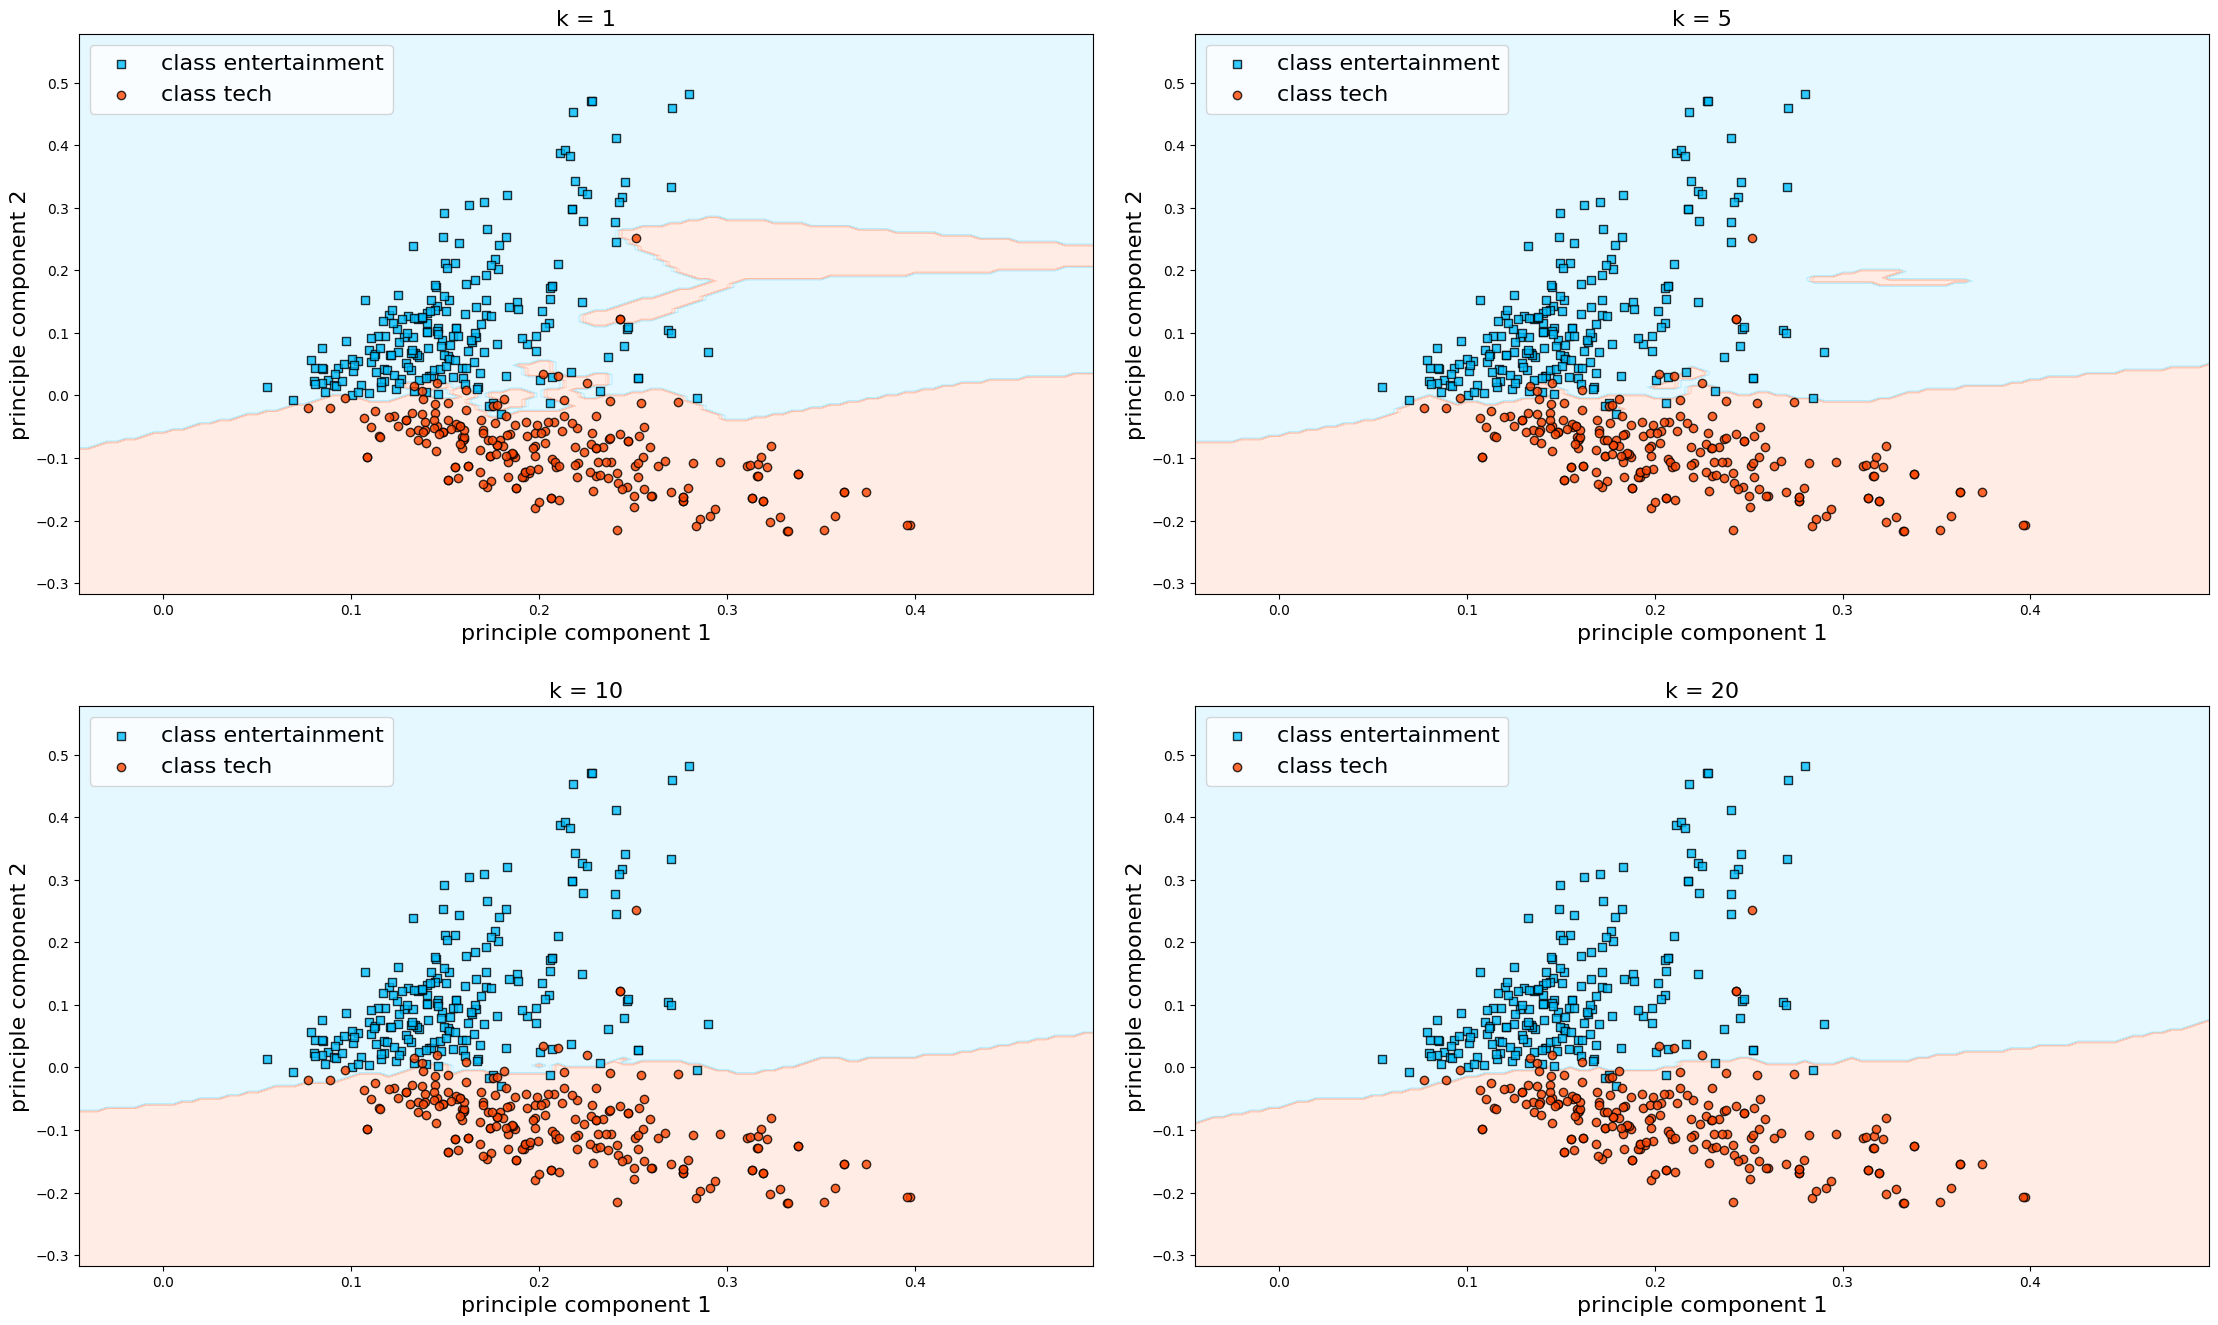

In [21]:
pca_knn = TruncatedSVD(n_components=2)
pca_train_tfidf = pca_knn.fit_transform(X_all_tfidf)

fig, ax = plt.subplots(2, 2, figsize=(24, 16))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, k in zip(ax.flatten(), [1, 5, 10, 20]): 
    model = KNeighborsClassifier(n_neighbors=k, metric="euclidean").fit(pca_train_tfidf, y_all)
    plot_surface(pca_knn, pca_train_tfidf, y_all, model, axi, inverse_transform=False)
    axi.set_title(f'k = {k}', size=16)

Using different distance metrics have different influences on the decision boundary. The decison boundary for Euclidean and Minkowski distance metric are nearly identical. Some overfitting can be observed around outliers. The boundary between the "entertainment" and "tech" catgories are rough. The cosine desion boundary is smoother than the previous two. The decision boundary closely resembles a straight line. However, there are some instances of overfitting where the sections of the "tech" category is highlighted as "entertainment", even though there are no observable influential points.

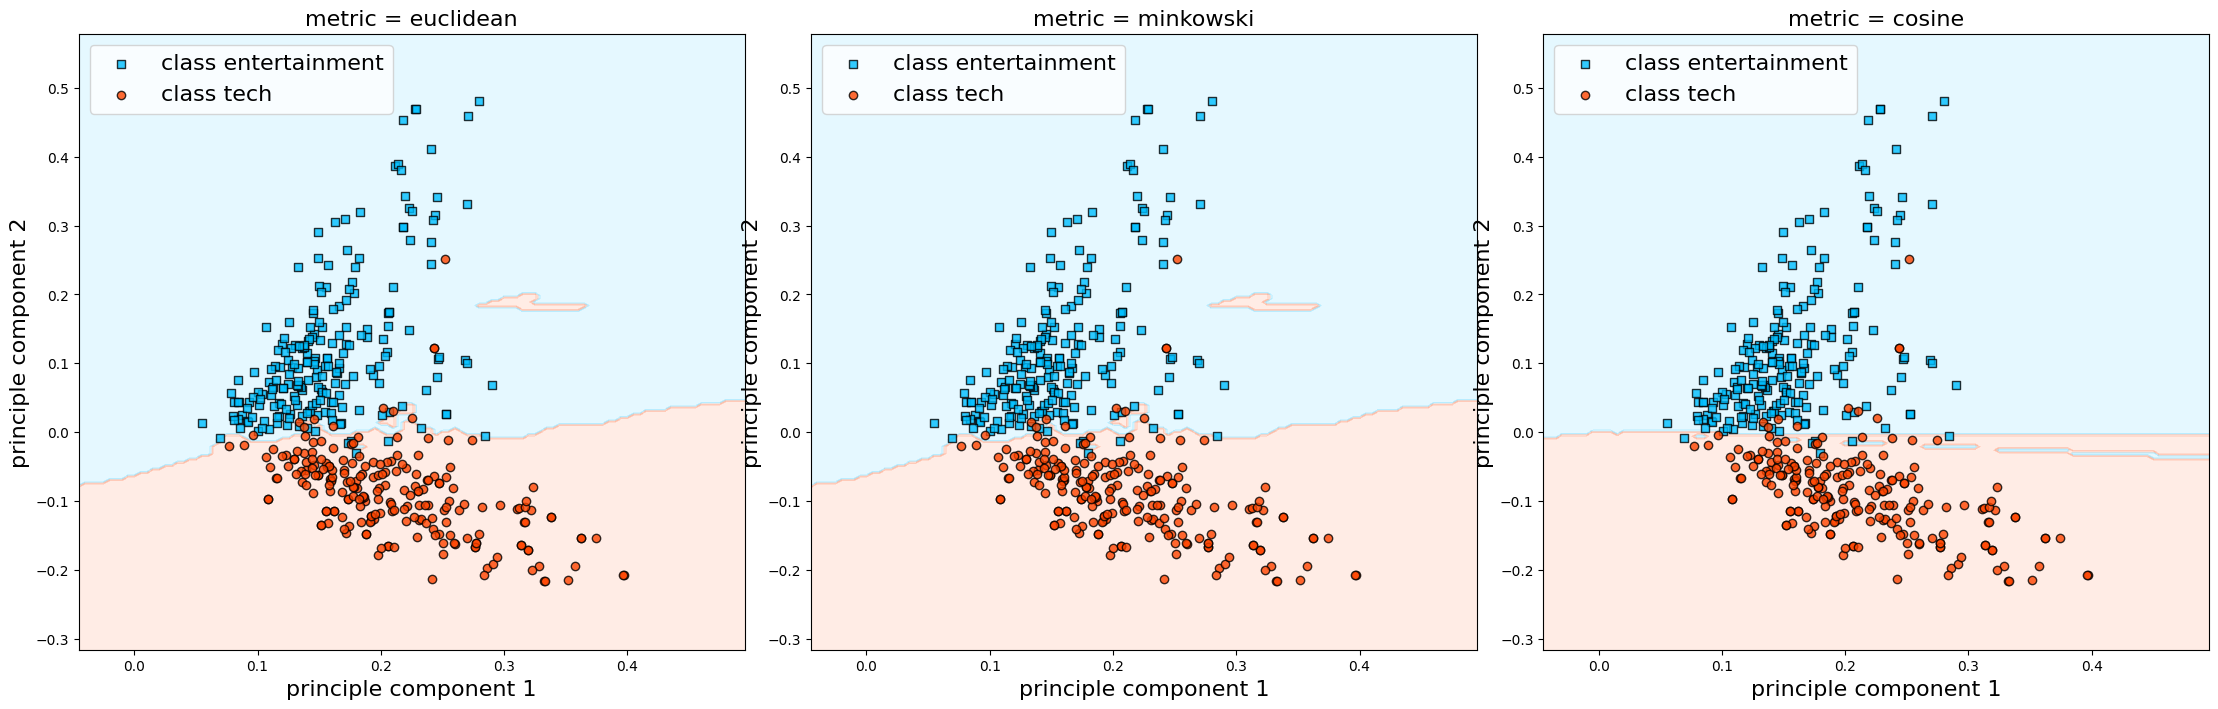

In [22]:
pca_knn = TruncatedSVD(n_components=2)
pca_train_tfidf = pca_knn.fit_transform(X_all_tfidf)

fig, ax = plt.subplots(1, 3, figsize=(24, 8))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, m in zip(ax, ["euclidean", "minkowski", "cosine"]): 
    model = KNeighborsClassifier(n_neighbors=5, metric=m).fit(pca_train_tfidf, y_all)
    plot_surface(pca_knn, pca_train_tfidf, y_all, model, axi, inverse_transform=False)
    axi.set_title(f'metric = {m}', size=16)

### Task 2.c) Support Vector Machine
Two SVM classification models are trained on the training set. The first is a soft-margin linear SVM, and the effect of four misclassificaiton penalties are investigated. The second is a hard-margin RBF kernal SVM, and the effect of four kernel widths are investigated

#### Impact of C on the Soft-Margin Linear SVM
Four misclassifcation penalties, C = [0.05, 0.1, 0.5, 1], have been explored. The boundary is linear. The four surface plots use inverse transformation of the PCA to predict each pixel. As with kNN, most of the information is lost during the PCA transformation. However, the effect of the misclassifcaiton penalty C can be observed. 

When the misclassificaton penalty is low, the positive "tech" category is prefered more. As the misclassificaition penalty increases, a better classification of each category can be observed. A misclassification penalty of 0.5 and 1 is better than 0.1. However, the full effect of the misclassification penalty is difficult to see. A direct correlation between the boundary and the surface plot is not possible as the classifed points are based on the inverse transformation.


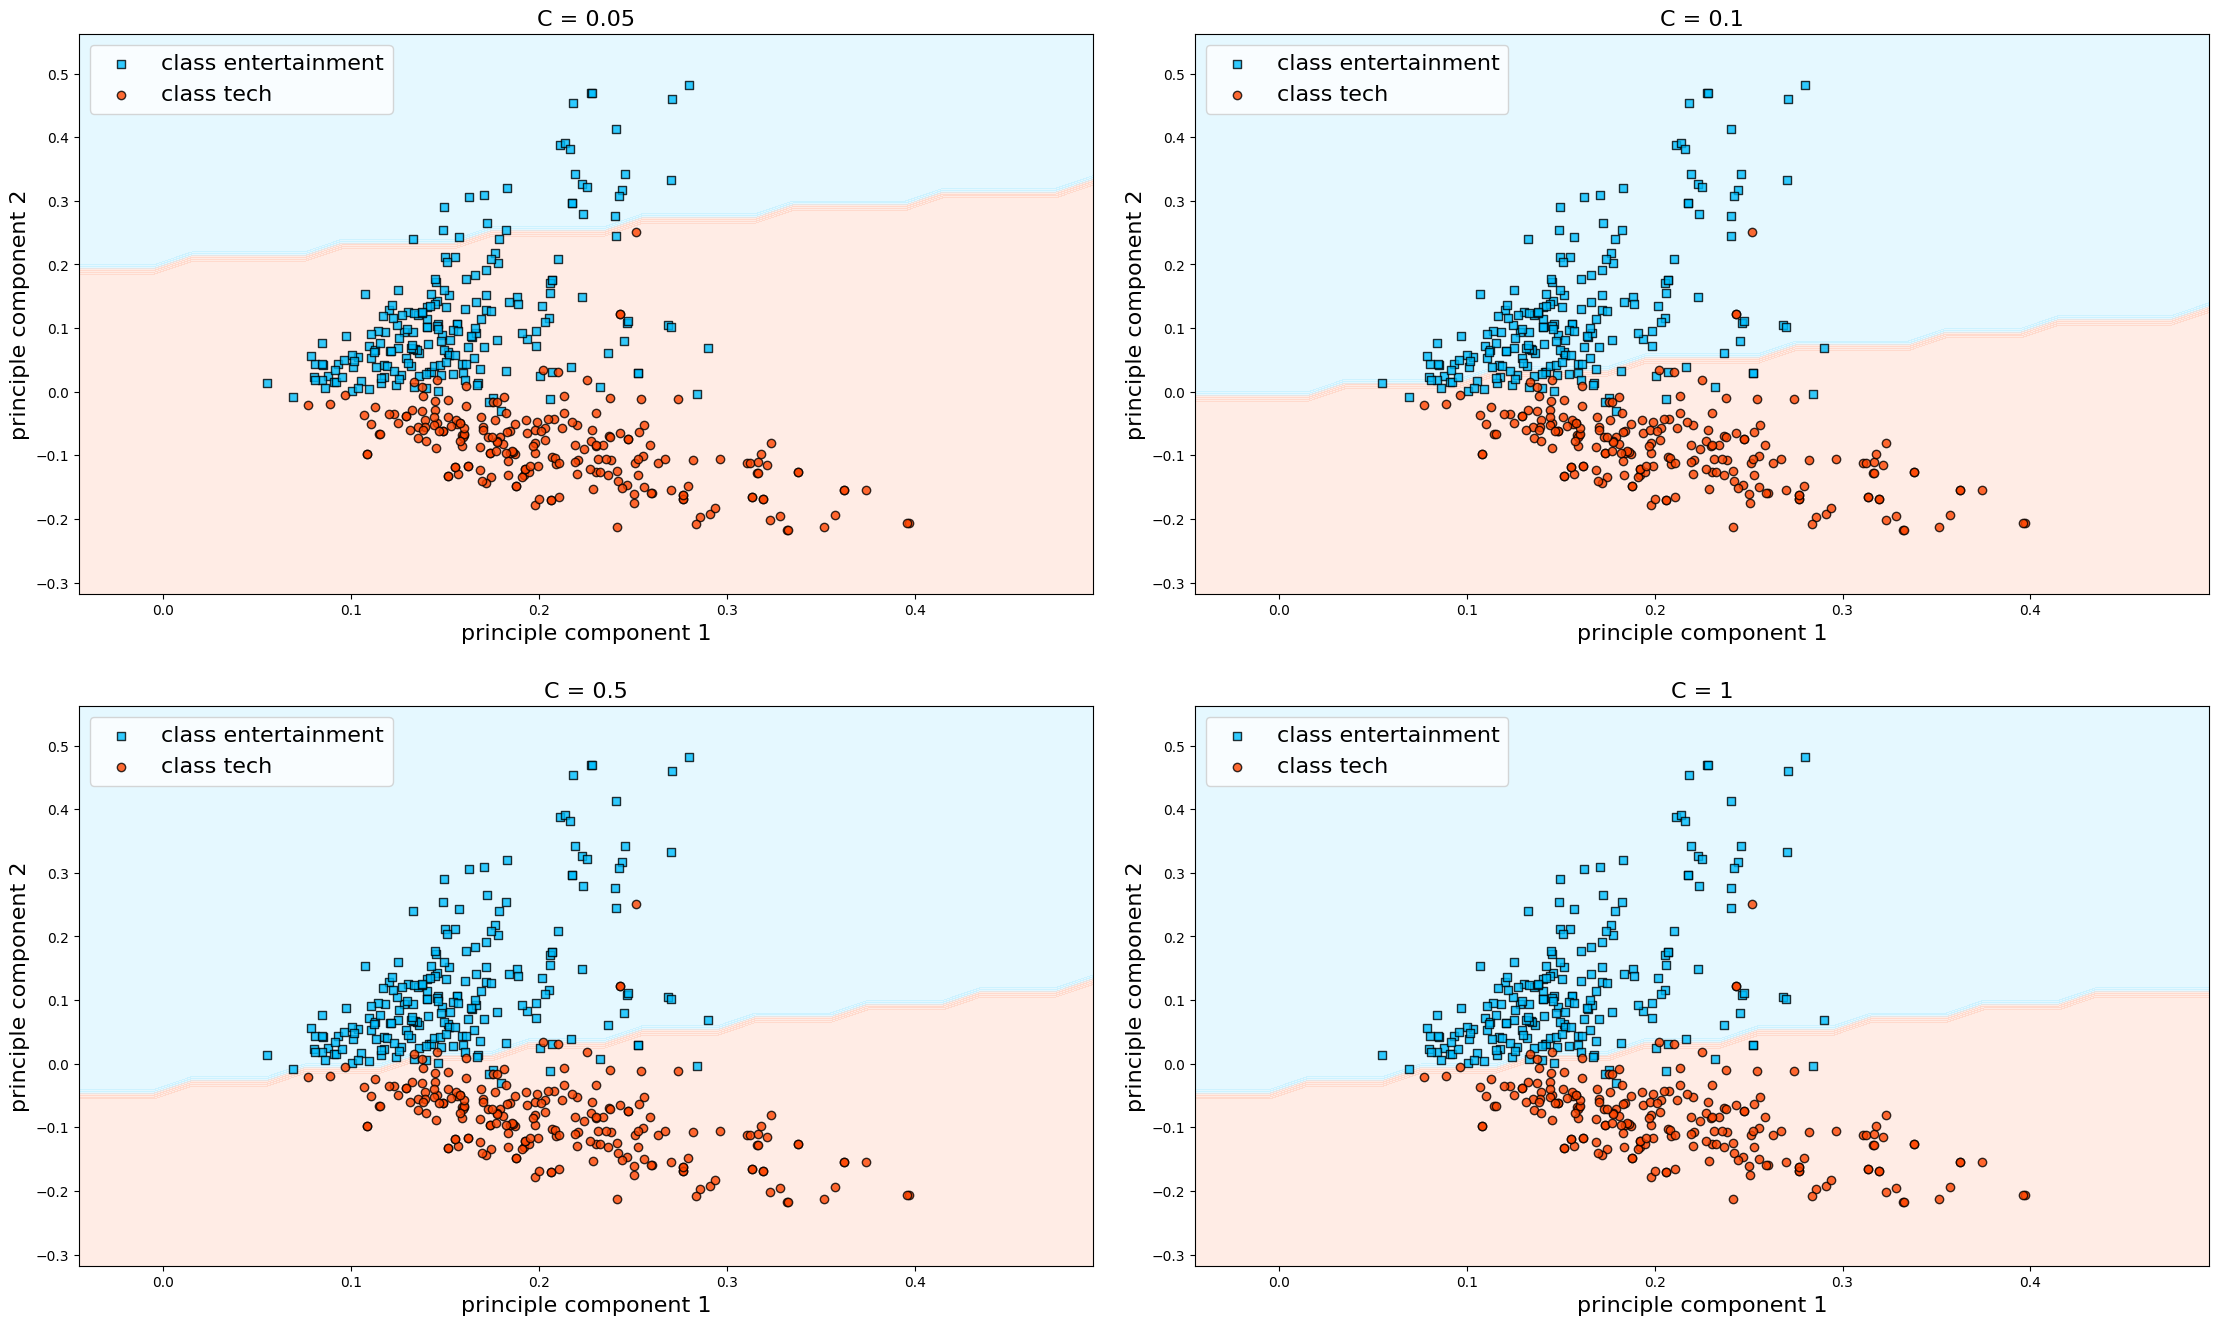

In [23]:
pca_linear_svm = TruncatedSVD(n_components=2)
pca_tfidf_svm = pca_linear_svm.fit_transform(X_all_tfidf)

fig, ax = plt.subplots(2, 2, figsize=(24, 16))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, c in zip(ax.flatten(), [0.05, 0.1, 0.5, 1]): 
    model = SVC(kernel="linear", C=c).fit(X_all_tfidf, y_all)
    plot_surface(pca_linear_svm, pca_tfidf_svm, y_all, model, axi, resolution=0.02)
    axi.set_title(f'C = {c}', size=16)

#### Impact of kernel width Hard-Margin RBF with varying kernel width
Four kernel widths, gamma = [0.05, 0.1, 0.5, 1], have been explored. The first set of graphs displays surface plot using inverse transformation of the PCA. Most of the information is lost during the PCA transformation. The decison boundaries look similar, as the exact boundaries cannot be projected to a 2D plane. To visualise the effect of the misclassifcation penalty, the classifer has been trained using only on the principal components. Because a lot of information is lost, this classifer has low accuracy and would not be used for the actual classification.


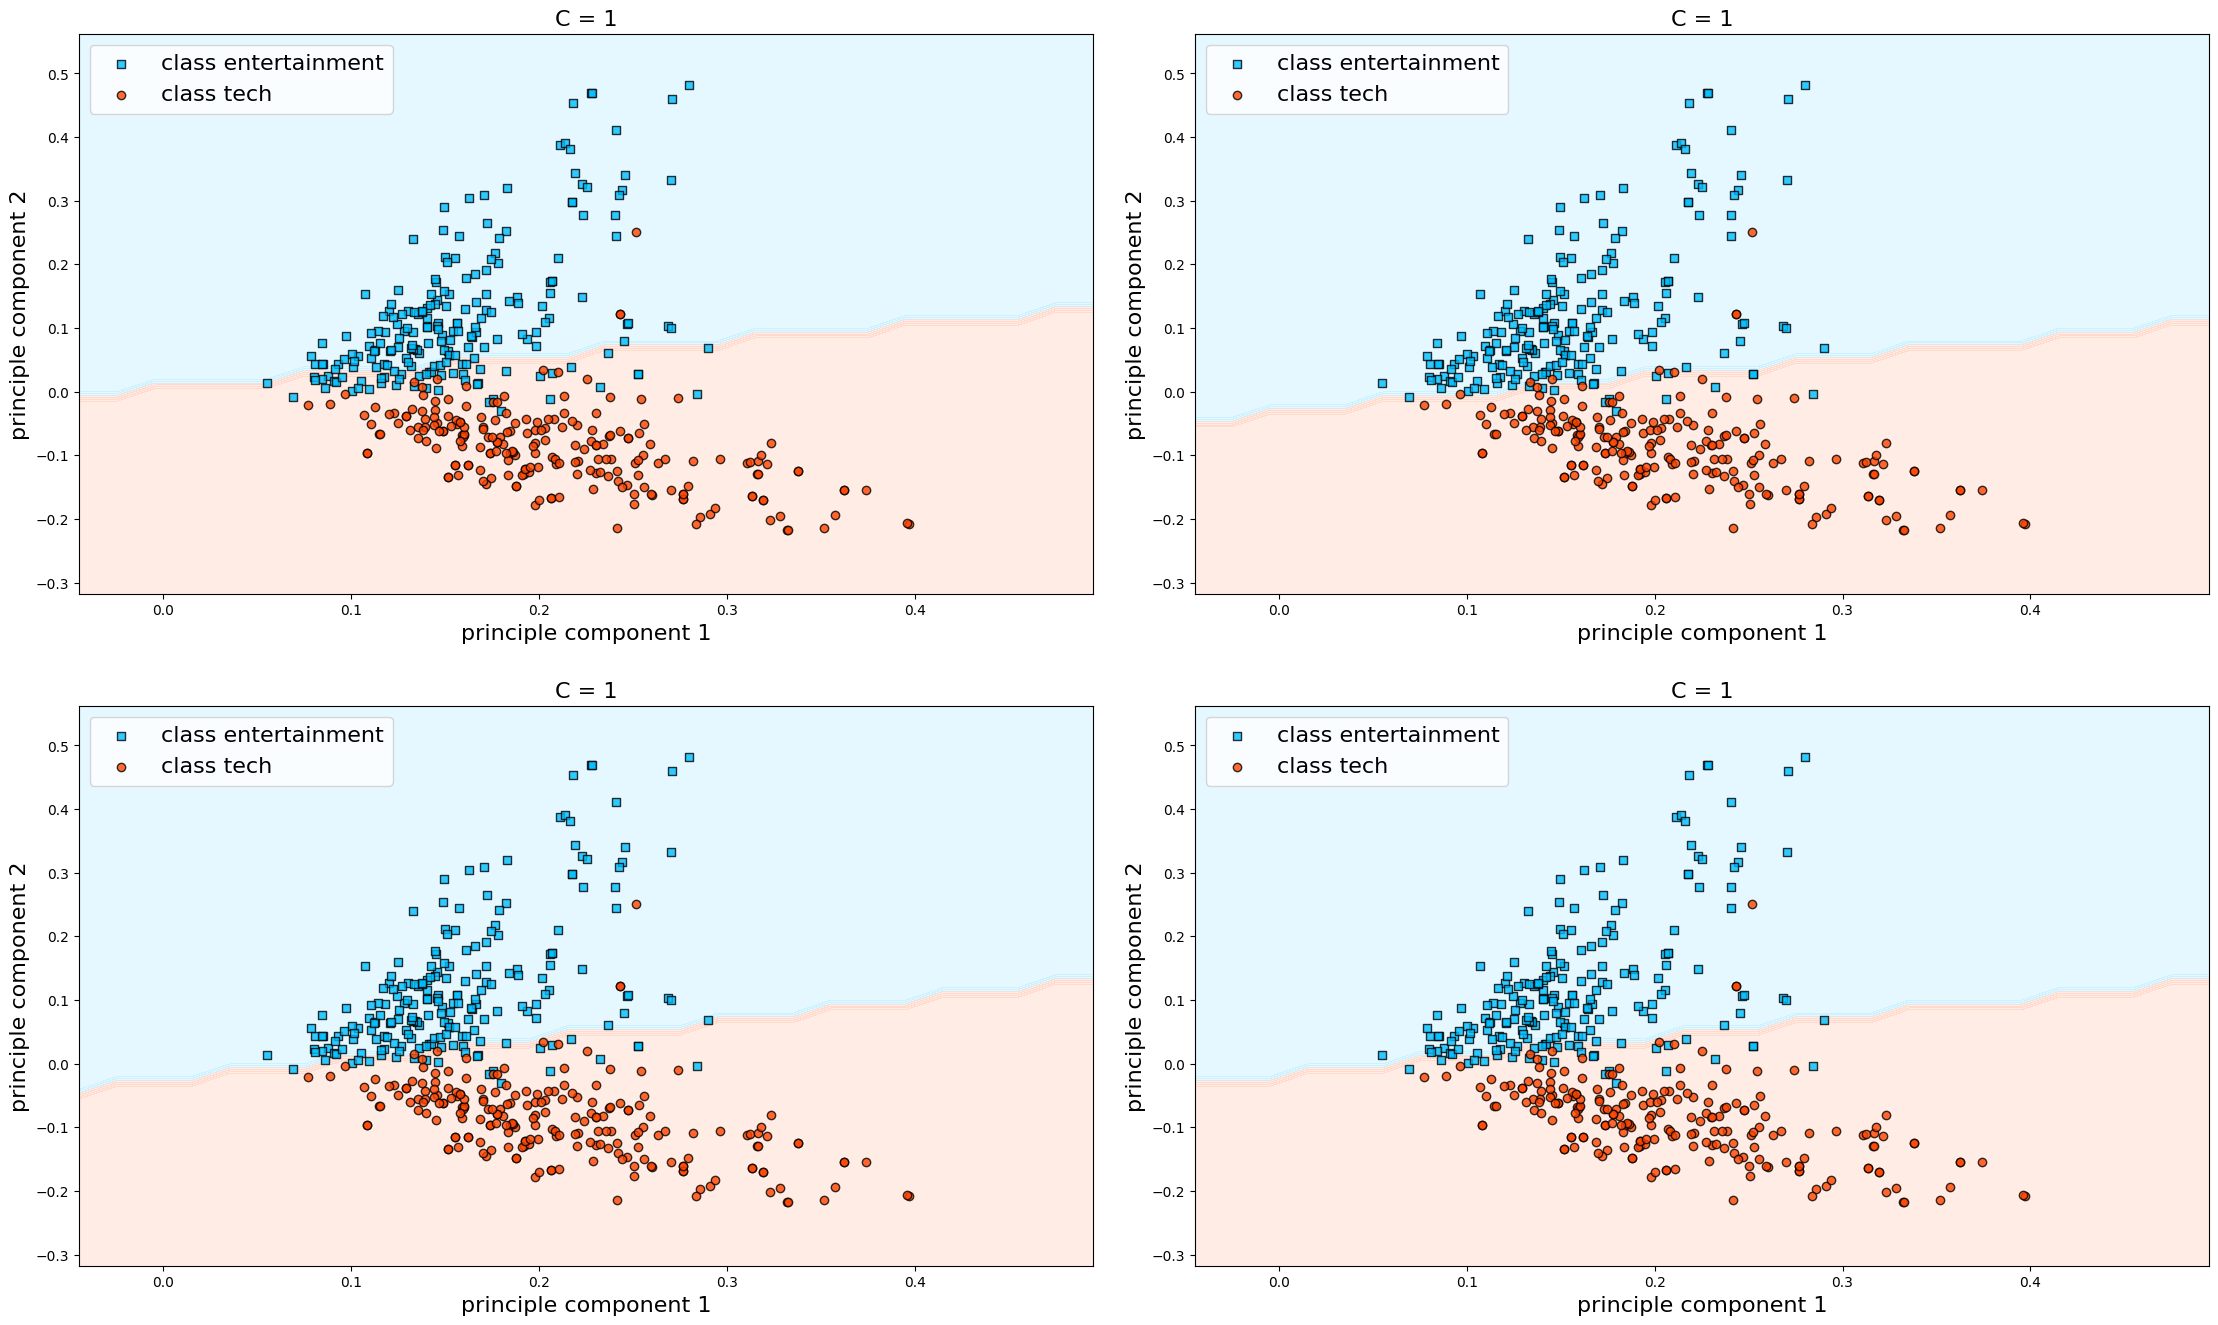

In [24]:
pca_linear_svm = TruncatedSVD(n_components=2)
pca_tfidf_svm = pca_linear_svm.fit_transform(X_all_tfidf)


fig, ax = plt.subplots(2, 2, figsize=(24, 16))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, g in zip(ax.flatten(), [0.05, 0.1, 0.5, 1]): 
    model = SVC(kernel="rbf", gamma=g).fit(X_all_tfidf, y_all)
    plot_surface(pca_linear_svm, pca_tfidf_svm, y_all, model, axi, resolution=0.02)
    axi.set_title(f'C = {c}', size=16)





The effect of the gamma hyperparamter is more noticeable after training the SVM classifier on only the first two principal components. When the gamma hyperparamter is small, the kernel width is wide. A smoother decision boundary can be observed, such as for when gamma = 1. When gamma = 1, the surface plot is similar to the surface plot of a linear SVM. As gamma increases, the kernel is narrower. Each data point have a greater influence on the decision boundary. While the decision boundaries for gamma = 10 and 100 look reasonably smooth, the decision margins are different. When gamma = 10, the decision margin is convex. The decision margin in non-convex for the entertainment class when gamma = 100. When gamma is very large, overfitting can be observed. The SVM observers patterns not present in the data, and puts the decision margin around pockets of denser areas within the same class.

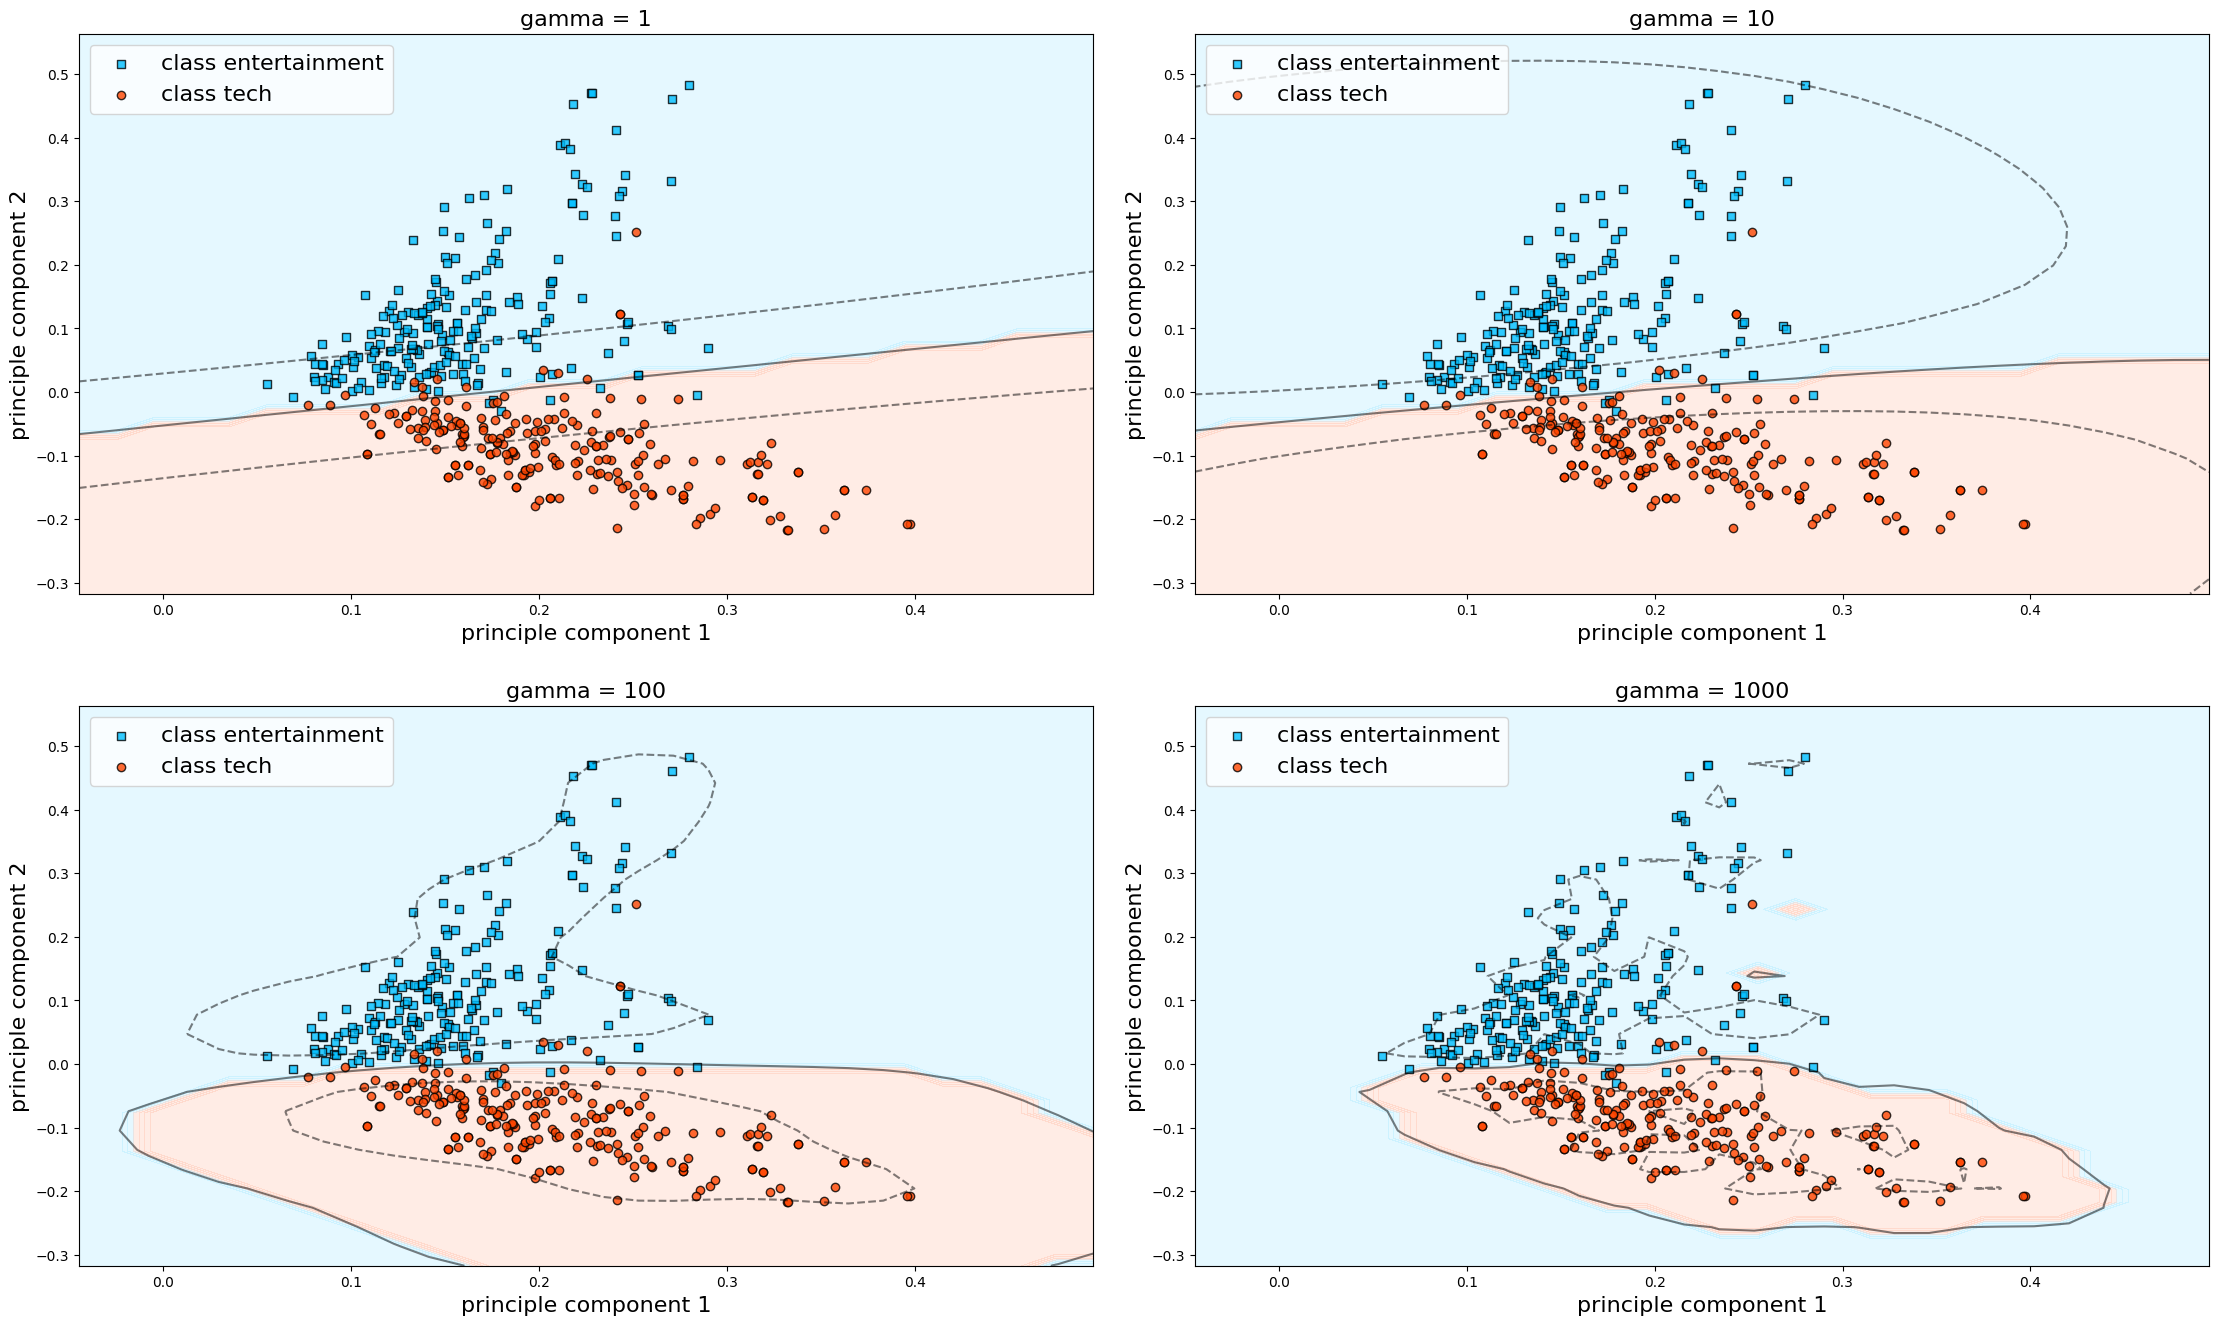

In [25]:
pca_rbf_svm = TruncatedSVD(n_components=2)
pca_tfidf_svm = pca_rbf_svm.fit_transform(X_all_tfidf)


fig, ax = plt.subplots(2, 2, figsize=(24, 16))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, g in zip(ax.flatten(), [1, 10, 100, 1000]): 
    model = SVC(kernel="rbf", gamma=g).fit(pca_tfidf_svm, y_all)
    plot_surface(pca_rbf_svm, pca_tfidf_svm, y_all, model, axi, resolution=0.02, inverse_transform=False, decision_margin=True)
    axi.set_title(f'gamma = {g}', size=16)



### Task 2.d) Neural Network
A neural network is trained on all the dataset. The initial weights are uniformly drawn between 0 and 0.1 inclusive, with learning rate 0.01. A single hidden layer is used, wheere the number of hidden units vary between 5, 20, and 40. The ReLU activation function has been used, and the solver for the weight optimser is Stochastic Gradient Descent.

From looking at our plot, it seems increasing the number of hidden units tends to also increase the cross entropy loss. This seems unusual in beggining as we would expect the model to be more accurate with more units thus less entropy loss. However, it seems the model could have been overfit quite easily with the added nodes in the hidden layer. The model learned the outliers more than the underlying pattern.


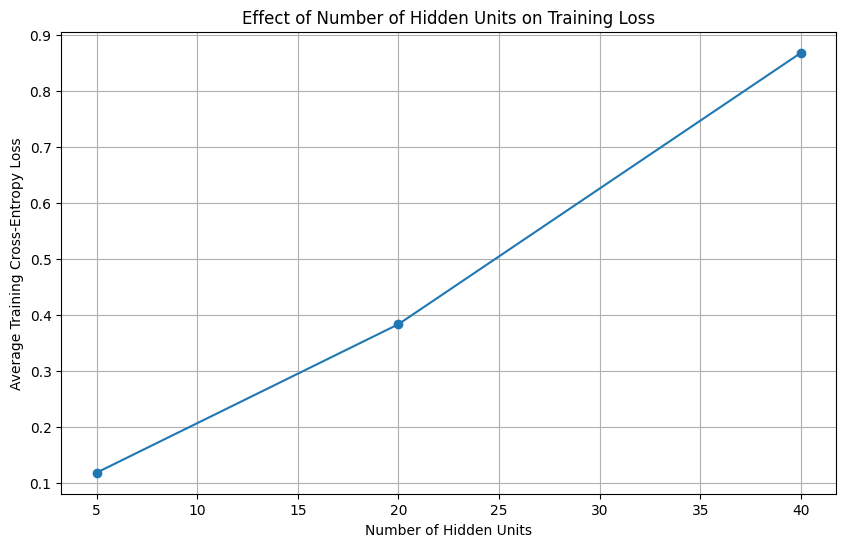

In [10]:
learning_rate_init = 0.01
max_iter = 100
hidden_units_list = [5, 20, 40]

average_training_losses = []

for hidden_units in hidden_units_list:
    mlp = MLPClassifier(hidden_layer_sizes=(hidden_units,),
                        activation='relu',
                        solver='sgd',
                        learning_rate_init=learning_rate_init,
                        max_iter= 100, 
                        warm_start=True, 
                        random_state=42)
    
    #weight initialization
    def init_weights(m):
        if isinstance(m, MLPClassifier):
            for layer in m.coefs_:
                layer[:] = np.random.uniform(0, 0.1, layer.shape)
                
    mlp._fit(X_all_count, y_all)
    init_weights(mlp)
    
    training_losses = []
    training_accuracies = []
    
    for epoch in range(max_iter):
        mlp.partial_fit(X_all_count, y_all, classes=np.unique(y_test))
        y_train_pred = mlp.predict_proba(X_all_count)
        loss = log_loss(y_all, y_train_pred)
        training_losses.append(loss)

    average_training_loss = np.mean(training_losses)
    average_training_losses.append(average_training_loss)

plt.figure(figsize=(10, 6))
plt.plot(hidden_units_list, average_training_losses, marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Average Training Cross-Entropy Loss')
plt.title('Effect of Number of Hidden Units on Training Loss')
plt.grid(True)
plt.show()


## Task 3: Classification Quality Evaluation

In [11]:
data_test_csv = pd.read_csv("test.csv")

X_test_all = data_test_csv["Text"]
y_test_all = data_test_csv["Category"]

Naive Bayes model training: with split = 0.1 scores result 1.0
Naive Bayes model: with split = 0.1 scores result: 0.9375
KNN model training: with split = 0.1 scores result 0.9545454545454546
KNN model: with split = 0.1 scores result: 0.967032967032967
SVM model training: with split = 0.1 scores result 1.0
SVM model: with split = 0.1 scores result: 0.989010989010989
Neural Network model training: with split = 0.1 scores result 1.0
Neural Network model: with split = 0.1 scores result: 0.9361702127659575
Naive Bayes model training: with split = 0.3 scores result 1.0
Naive Bayes model: with split = 0.3 scores result: 0.9782608695652174
KNN model training: with split = 0.3 scores result 0.9922480620155039
KNN model: with split = 0.3 scores result: 0.9772727272727273
SVM model training: with split = 0.3 scores result 1.0
SVM model: with split = 0.3 scores result: 0.967032967032967
Neural Network model training: with split = 0.3 scores result 1.0
Neural Network model: with split = 0.3 scores 

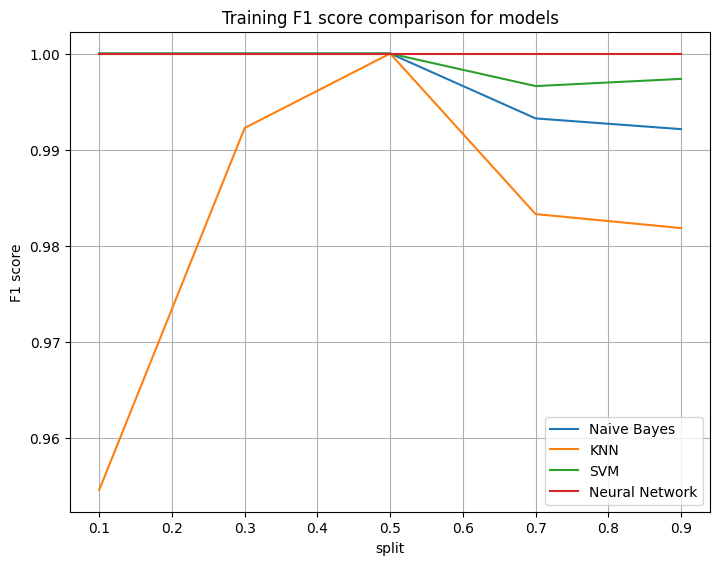

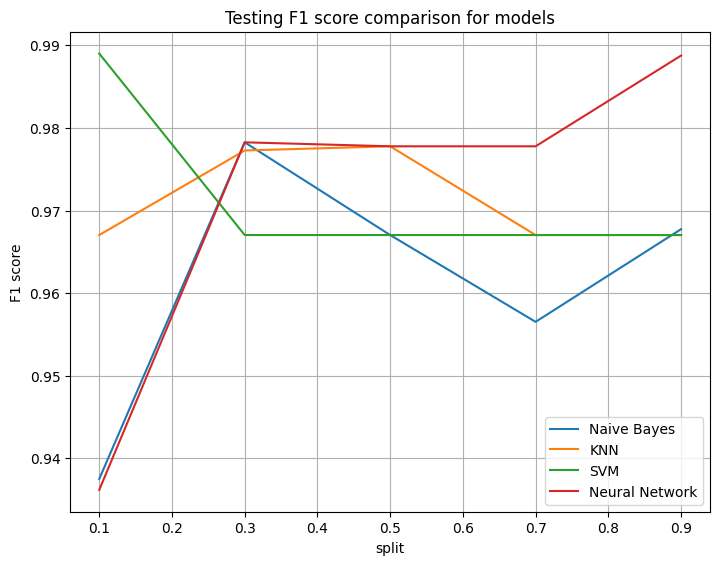

In [13]:
splits = [0.1, 0.3, 0.5, 0.7, 0.9]

nb_3a = MultinomialNB()
knn_3a = KNeighborsClassifier(n_neighbors=20, metric="cosine")
svm_3a = SVC(kernel="linear", C=1)
mlp_3a = model = MLPClassifier(hidden_layer_sizes=(20,),
                        activation='relu',
                        solver='sgd',
                        learning_rate_init=0.01,
                        max_iter=1, 
                        warm_start=True, 
                        random_state=42)

models = {"Naive Bayes": nb_3a, "KNN": knn_3a, "SVM": svm_3a, "Neural Network": mlp_3a}


results_train = {}
results_test = {}
for split in splits:
    for name, model in models.items():

        X_train, _, y_train, _ = train_test_split(X_all, y_all, test_size= 1-split, random_state=42)
        
        # Vectorise
        vectorizer_3a = TfidfVectorizer()
        # fit training set to vectoriser
        X_train_tfidf = vectorizer_3a.fit_transform(X_train)
        # transform testing set to vectoriser
        X_test_tfidf = vectorizer_3a.transform(X_test_all)

        if name == "Neural Network":
            count_vectorizer_3a = CountVectorizer()
              # fit training set to vectoriser
            X_train_tfidf = count_vectorizer_3a.fit_transform(X_train)
            # transform testing set to vectoriser
            X_test_tfidf = count_vectorizer_3a.transform(X_test_all)
            model = MLPClassifier(hidden_layer_sizes=(20,),
                        activation='relu',
                        solver='sgd',
                        learning_rate_init=0.01,
                        max_iter=100, 
                        warm_start=True, 
                        random_state=42)
            model.fit(X_train_tfidf, y_train)
        else:
            model.fit(X_train_tfidf, y_train)

        y_pred_train = model.predict(X_train_tfidf)
        measure_train = f1_score(y_train, y_pred_train, pos_label = 'tech')

        y_pred_test = model.predict(X_test_tfidf)
        measure_test = f1_score(y_test_all, y_pred_test, pos_label = 'tech')

        results_train[name] = results_train.get(name, [[],[]])
        results_train[name][0].append(split); results_train[name][1].append(measure_train)
        print(f'{name} model training: with split = {split} scores result {measure_train}')

        results_test[name] = results_test.get(name, [[],[]])
        results_test[name][0].append(split); results_test[name][1].append(measure_test)
        print(f'{name} model: with split = {split} scores result: {measure_test}')




fig = plt.figure()
ax = fig.add_axes((0,0,1,1))
for name in models.keys():
    ax.plot(results_train[name][0], results_train[name][1], label = name)
ax.set_xlabel("split")
ax.set_ylabel("F1 score")
ax.set_title("Training F1 score comparison for models")
plt.legend()
plt.grid()
plt.show()


fig = plt.figure()
ax = fig.add_axes((0,0,1,1))
for name in models.keys():
    ax.plot(results_test[name][0], results_test[name][1], label = name)
ax.set_xlabel("split")
ax.set_ylabel("F1 score")
ax.set_title("Testing F1 score comparison for models")
plt.legend()
plt.grid()
plt.show()

(a) We investigated the effects of the amount of training data used to construct the models on the f1-score accuracy of the model. 

Looking at the plot, as we increase the amount of training data, the training accuracy seems to decrease for all models except K nearest neighbours.
Looking at the testing data, we find the accuracy tends to increase, but generally appears more random than increasing.

For training accuracy:
Generally we found KNN least effective for low data levels. 
We also found that once each model had more than 50% of the training data, they suprisingly performed worse.

For testing accuracy:
Generally, we found Naive Bayes to be a less effective model in the training accuracy at all data levels.
We found the neural network to be one of the weakest models on less data, but much more effective as we increased the amount of training data.

However all trends shown here are not very strong, as we tend to find the accuracy is 0.93 and 1, we also tend to find that the models have a lot of randomness towards the effect of data sizes. So it's not a very strong trend.

(b) Let’s use 5-fold cross-validation to assess model performance. Investigate the impact of key
hyperparameters of your choices for each classifier using a testing dataset. E.g., for SVM, the
classification accuracy may be significantly affected by the kernels and hyperparameter
combination. List hyperparameters for each classifier and demonstrate how these
hyperparameters impact on the testing accuracy.


Train on train data

Predict on testing data: test once for each model




In [23]:
f1_scorer = make_scorer(f1_score, pos_label = "tech")

# nb
NBmodel = MultinomialNB()
scores = cross_val_score(NBmodel, X_all_count, y_all, cv=5, scoring = f1_scorer)
avg_scores = np.mean(scores)

print(f"Naive Bayes Average 5-fold CV Score: {avg_scores}")

NBmodel.fit(X_all_count, y_all)
y_pred_test = NBmodel.predict(testing)
f1 = f1_score(y_testing, y_pred_test, pos_label = "tech")
print(f"Naive Bayes Test Accuracy: {f1}")

Naive Bayes Average 5-fold CV Score: 0.9812852807522369
Naive Bayes Test Accuracy: 0.967741935483871


In [21]:
# knn
knn_n_neighbors = [1, 10, 20, 30, 40, 50]
knn_dist_metric = ["euclidean", "minkowski", "cosine"]

f1_scorer = make_scorer(f1_score, pos_label = "tech")

for dist_metric in knn_dist_metric:
    for n in knn_n_neighbors:
        fold_scores = []
        knn = KNeighborsClassifier(metric = dist_metric, n_neighbors = n)
        cv_scores = cross_val_score(knn, X_all_count, y_all, cv=5, scoring = f1_scorer)
        avg_f1 = np.mean(cv_scores)
        
        print(f"KNN Average 5-fold CV Score with {n} neighbors and {dist_metric}: {avg_f1}")
        
        knn.fit(X_all_count, y_all)
        y_pred_test = knn.predict(testing)
        f1 = f1_score(y_testing, y_pred_test, pos_label = "tech")
        print(f"KNN Test Accuracy with {n} neighbors and {dist_metric}: {f1}")


KNN Average 5-fold CV Score with 1 neighbors and euclidean: 0.8029596920864528
KNN Test Accuracy with 1 neighbors and euclidean: 0.875
KNN Average 5-fold CV Score with 10 neighbors and euclidean: 0.2938430897765247
KNN Test Accuracy with 10 neighbors and euclidean: 0.5
KNN Average 5-fold CV Score with 20 neighbors and euclidean: 0.1412326563232587
KNN Test Accuracy with 20 neighbors and euclidean: 0.23529411764705882
KNN Average 5-fold CV Score with 30 neighbors and euclidean: 0.04406675450153711
KNN Test Accuracy with 30 neighbors and euclidean: 0.0851063829787234
KNN Average 5-fold CV Score with 40 neighbors and euclidean: 0.044848484848484846
KNN Test Accuracy with 40 neighbors and euclidean: 0.0
KNN Average 5-fold CV Score with 50 neighbors and euclidean: 0.017777777777777778
KNN Test Accuracy with 50 neighbors and euclidean: 0.0
KNN Average 5-fold CV Score with 1 neighbors and minkowski: 0.8029596920864528
KNN Test Accuracy with 1 neighbors and minkowski: 0.875
KNN Average 5-fold 

In [25]:
# svm

svm_gamma = [0.0001, 0.001, 0.01, 0.1, 1, 10]
svm_c = [0.05, 0.1, 0.5, 1]
svm_kernel = ["rbf", "linear"]

for kernel in svm_kernel:
    if kernel == "rbf":
        for g in svm_gamma:
            svm = SVC(kernel = kernel, gamma = g)
            cv_scores = cross_val_score(svm, X_all_count, y_all, cv=5, scoring = f1_scorer)
            avg_f1 = np.mean(cv_scores)
    
            print(f"SVM Average 5-fold CV Score with Hard Margin RBF and gamma = {g}: {avg_f1}")
            
            svm.fit(X_all_count, y_all)
            y_pred_test = svm.predict(testing)
            f1 = f1_score(y_testing, y_pred_test, pos_label = "tech")
            print(f"SVM Test Accuracy with Hard Margin RBF and gamma = {g}: {f1}")

    if kernel == "linear":
        for c in svm_c:
            fold_scores = []
            
            svm = SVC(kernel = kernel, C = c)
            cv_scores = cross_val_score(svm, X_all_count, y_all, cv=5, scoring = f1_scorer)
            avg_f1 = np.mean(cv_scores)
            
            print(f"SVM Average 5-fold CV Score with Soft Margin SVM and c = {c}: {avg_f1}")
            
            svm.fit(X_all_count, y_all)
            y_pred_test = svm.predict(testing)
            f1 = f1_score(y_testing, y_pred_test, pos_label = "tech")
            print(f"SVM Test Accuracy with Soft Margin SVM and c = {c}: {f1}")

SVM Average 5-fold CV Score with Hard Margin RBF and gamma = 0.0001: 0.8576213913824458
SVM Test Accuracy with Hard Margin RBF and gamma = 0.0001: 0.9534883720930233
SVM Average 5-fold CV Score with Hard Margin RBF and gamma = 0.001: 0.9554409254977877
SVM Test Accuracy with Hard Margin RBF and gamma = 0.001: 0.9887640449438202
SVM Average 5-fold CV Score with Hard Margin RBF and gamma = 0.01: 0.8207643845430255
SVM Test Accuracy with Hard Margin RBF and gamma = 0.01: 0.822429906542056
SVM Average 5-fold CV Score with Hard Margin RBF and gamma = 0.1: 0.31210859728506785
SVM Test Accuracy with Hard Margin RBF and gamma = 0.1: 0.36363636363636365
SVM Average 5-fold CV Score with Hard Margin RBF and gamma = 1: 0.27830652260904365
SVM Test Accuracy with Hard Margin RBF and gamma = 1: 0.36363636363636365
SVM Average 5-fold CV Score with Hard Margin RBF and gamma = 10: 0.22847069040382112
SVM Test Accuracy with Hard Margin RBF and gamma = 10: 0.3018867924528302
SVM Average 5-fold CV Score wi

In [30]:
#DELETE
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
scoring = {'f1_score' : make_scorer(f1_score)}
NBmodel = MultinomialNB()
scores = cross_val_score(NBmodel, X_all_tfidf, y_all, cv=5, scoring='f1')

print(scores)
# print(np.mean(scores))


# for train_index, val_index in kf.split(X_all_count):
#     X_train, X_val = X_all_count[train_index], X_all_count[val_index]
#     y_train, y_val = y_all[train_index], y_all[val_index]

#     NBmodel.fit(X_train, y_train)
#     y_pred = NBmodel.predict(X_val)
#     f1 = f1_score(y_val, y_pred, pos_label = "tech")
#     NB_fold_scores.append(f1)

# avg_f1 = np.mean(NB_fold_scores)
# print(f"Naive Bayes Average 5-fold CV Score: {avg_f1}")

# NBmodel.fit(X_all_count, y_all)
# y_pred_test = NBmodel.predict(testing)
# f1 = f1_score(y_testing, y_pred_test, pos_label = "tech")
# print(f"Naive Bayes Test Accuracy: {f1}")

[nan nan nan nan nan]


In [ ]:
for

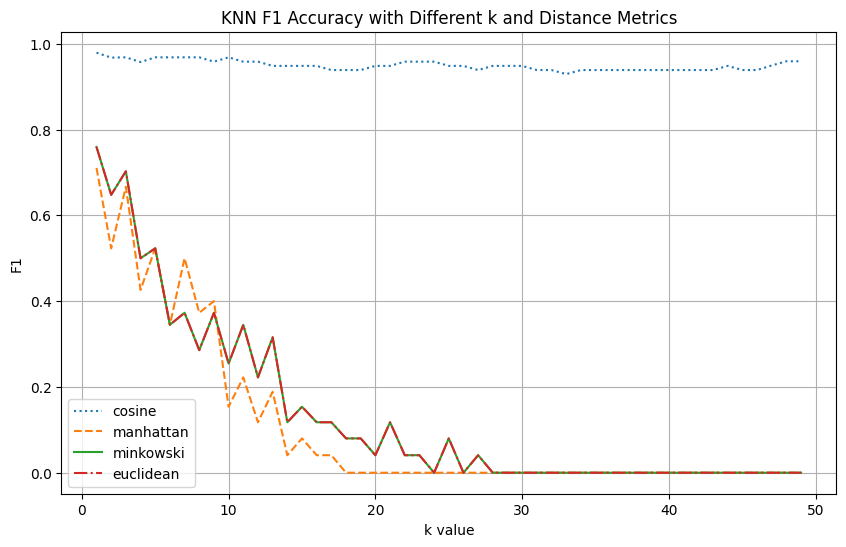

In [60]:
# graph of accuracy with different k and distance metrics

from sklearn import metrics

k_values = range(1, 50)
dist_metrics = ["cosine", "manhattan", "minkowski", "euclidean"]
accuracy_results = {}

for metric in dist_metrics:
    accuracy_results[metric] = []
    knn = KNeighborsClassifier(metric = metric)
    for k in k_values:
        knn.n_neighbors = k
        knn.fit(X_train_count, y_train)
        y_pred = knn.predict(X_test_count)
        # print(metrics.f1_score(y_test, y_pred,average="binary", pos_label="tech") )
        measure = f1_score(y_test, y_pred,average="binary", pos_label="tech")
        accuracy_results[metric].append(measure)

plt.figure(figsize = (10, 6))
line_styles = [":", "--", "-", "-."]
for metric, accuracy_val, style in zip(accuracy_results.keys(), accuracy_results.values(), line_styles):
    plt.plot(k_values, accuracy_val, label = metric, linestyle = style)
plt.xlabel("k value")
plt.ylabel("F1")
plt.title("KNN F1 Accuracy with Different k and Distance Metrics")
plt.legend()
plt.grid(True)
plt.show()


When k is small, there is significant variability in the accuracy of the KNN model across all distance metrics. This is because a smaller k value means that the classifier is more sensitive to noise in the training data. As k increases, the accuracy tends to stabilize. The accuracies for manhattan, minkowski and euclidean distance metrics decrease gradually as k increases, converging to a stable but low value. Meanwhile, the accuracy of the cosine distance metric remains relatively high (> 0.9), suggesting that it is more robust to changes in k and can maintain high accuracy regardless of the value of k.


(c) Report and compare your NB, kNN, SVM and NN classifiers with the best hyperparameter
settings. Summarize what you have observed in the classification accuracy in 𝐹𝐹1 measure on
the testing dataset. 

The best hyperparameter settings for the classifiers are:
- Naive Bayes: no hyperparamters
- k Nearest Neighbours
